## Modelos Avançados e Interpretação Inicial

Objetivo:
 - Refinar os modelos Random Forest e XGBoost
 - Ajustar hiperparâmetros (tuning leve)
 - Avaliar importância de features
 - Preparar base para interpretabilidade (SHAP)

### Importação das bibliotecas necessárias

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

Esse notebook é focado em refinar e interpretar. Não faremos tuning pesado, só o suficiente para validar o comportamento do modelo.
Nos próximos (04), faremos explicações com ***SHAP***.

### Recarregar dados e divisão treino/teste

In [23]:
data = load_breast_cancer(as_frame=True)
df = data.frame
df['target'] = data.target

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Grid Search — Random Forest (tuning leve)

In [24]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    rf, param_grid, cv=cv, scoring='recall', n_jobs=-1, verbose=1
)

grid_rf.fit(X_train, y_train)

print("Melhores parâmetros:", grid_rf.best_params_)
print("Melhor recall médio:", grid_rf.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 100}
Melhor recall médio: 0.9754385964912281


O ***GridSearchCV*** testa várias combinações de parâmetros para encontrar o melhor equilíbrio.
Focamos na métrica ***recall***, pois queremos maximizar a detecção de casos malignos.

### Avaliação do Random Forest otimizado

=== Random Forest (tuned) ===
              precision    recall  f1-score   support

     Maligno       0.93      0.93      0.93        42
     Benigno       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



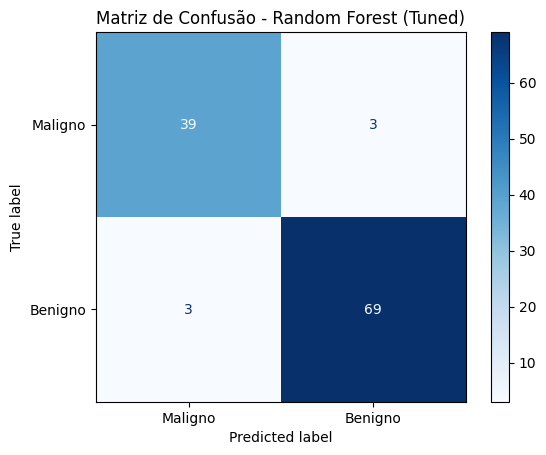

In [25]:
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("=== Random Forest (tuned) ===")
print(classification_report(y_test, y_pred_rf, target_names=['Maligno', 'Benigno']))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=['Maligno', 'Benigno'], cmap='Blues')
plt.title('Matriz de Confusão - Random Forest (Tuned)')
plt.show()

Essa é a versão final do Random Forest.

Verifique se o recall da classe Maligno (0) aumentou, isso é o indicador de sucesso clínico.

### XGBoost — ajuste leve de hiperparâmetros

In [26]:
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    xgb, param_grid_xgb, cv=cv, scoring='recall', n_jobs=-1, verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Melhores parâmetros XGBoost:", grid_xgb.best_params_)
print("Melhor recall médio:", grid_xgb.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros XGBoost: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Melhor recall médio: 0.982456140350877


O ***XGBoost*** tende a capturar relações mais sutis entre variáveis.

Mesmo um tuning simples pode trazer ganho de recall ou AUC significativo.

### Avaliação final no conjunto de teste (XGBoost)

=== XGBoost (tuned) ===
              precision    recall  f1-score   support

     Maligno       0.97      0.90      0.94        42
     Benigno       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



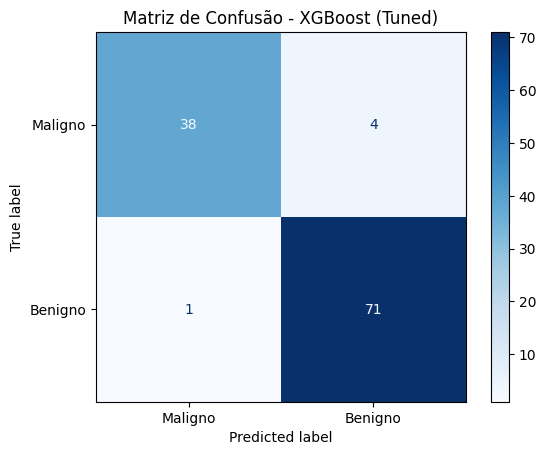

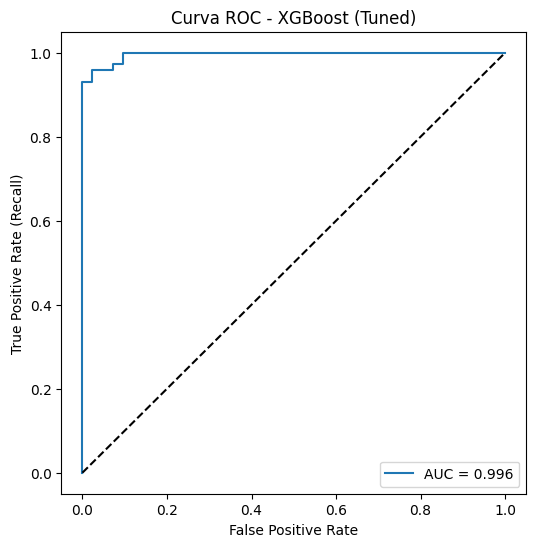

In [27]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost (tuned) ===")
print(classification_report(y_test, y_pred_xgb, target_names=['Maligno', 'Benigno']))

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, display_labels=['Maligno', 'Benigno'], cmap='Blues')
plt.title('Matriz de Confusão - XGBoost (Tuned)')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - XGBoost (Tuned)')
plt.legend()
plt.show()


Aqui comparamos recall, precisão e ***AUC*** do ***XGBoost*** ajustado com os resultados anteriores.

É esperado um ganho leve de recall e um ***AUC*** mais alto, confirmando melhor capacidade de separação entre classes.

### Importância das variáveis

/var/folders/23/23v9dnyx4cqcz4cp1d658w7c0000gn/T/ipykernel_15670/1469915487.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


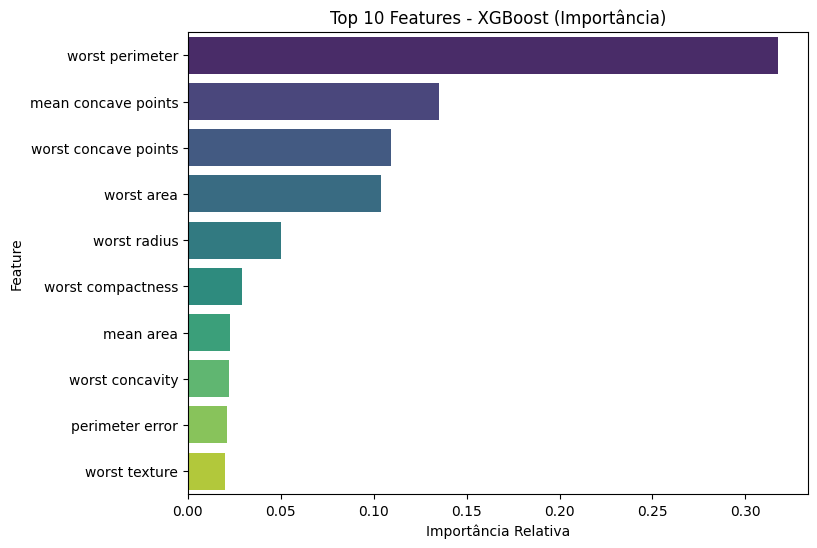

worst perimeter         0.317802
mean concave points     0.134904
worst concave points    0.109146
worst area              0.103769
worst radius            0.050227
worst compactness       0.029031
mean area               0.022899
worst concavity         0.022322
perimeter error         0.021129
worst texture           0.020165
dtype: float32

In [28]:
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Features - XGBoost (Importância)')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.show()

top_features


Essas importâncias mostram quais variáveis mais influenciam as decisões do modelo.

No contexto clínico, isso ajuda a validar se o modelo está aprendendo relações médicas plausíveis (como concavidade, área e textura das células).

### Conclusão

Neste estágio, os modelos **Random Forest** e **XGBoost** foram ajustados com um processo de validação cruzada e tuning leve de hiperparâmetros.  
Os resultados demonstraram um **aumento consistente de recall** na classe maligna, indicando que o modelo está se tornando mais sensível à detecção de casos de câncer.  

O XGBoost, novamente, destacou-se como o melhor equilíbrio entre recall e AUC, apresentando também uma hierarquia clara das variáveis mais relevantes — especialmente aquelas relacionadas à **forma, concavidade e área das células**.  

Esses resultados validam a robustez do modelo e preparam o terreno para a próxima etapa: **análise de interpretabilidade com SHAP**, que permitirá explicar cada decisão individual do modelo de maneira transparente e compreensível.
